# **AI PROJECT - IMAGE CAPTION GENERATOR - BY JESSICA MEHER**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# # Specifies the file paths for both the dataset of images and the corresponding caption file stored in Google Drive
dataset_path = '/content/drive/MyDrive/AI_project_by_JESSICA_MEHER/Flickr8K_DATASETS/Images'
caption_file = '/content/drive/MyDrive/AI_project_by_JESSICA_MEHER/Flickr8K_DATASETS/Flickr_TextData/Flickr8k.token.txt'

In [4]:
# Load and clean captions
def load_captions(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    captions = {}
    for line in lines:
        tokens = line.strip().split('\t')
        image_id = tokens[0].split('#')[0]
        caption = tokens[1].lower()
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(caption)
    return captions

def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^a-z ]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

captions_dict = load_captions(caption_file)


The above code loads captions from the file, groups them by image ID, and cleans each caption by removing special characters, converting to lowercase, and trimming spaces.

In [5]:
# Feature extraction
import os
import numpy as np
import pickle
from tqdm import tqdm
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

def extract_features_limited(directory, save_path='features.pkl', limit=50):
    base_model = VGG16(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    features = {}
    image_list = [img for img in os.listdir(directory) if img.lower().endswith('.jpg')][:limit]
    for img_name in tqdm(image_list):
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        features[img_name] = feature
    with open(save_path, 'wb') as f:
        pickle.dump(features, f)
    return features

features = extract_features_limited(dataset_path)

100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


The above code extracts visual features from a limited number of images using the pre-trained VGG16 model. Each image is resized, preprocessed, and passed through the model to obtain feature vectors, which are stored in a dictionary and saved for future use.

In [6]:

# Filter captions for extracted features
filtered_captions = {k: cleaned_captions[k] for k in features.keys() if k in cleaned_captions}

This line filters the cleaned captions to include only those whose corresponding image features were successfully extracted, ensuring that each caption used has a matching image.










In [7]:

# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

all_captions = []
for cap_list in filtered_captions.values():
    all_captions.extend(cap_list)

tokenizer = Tokenizer(oov_token='unk')
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in all_captions)


The above code prepares the tokenizer for the image captions. It first collects all captions into a single list, then initializes the tokenizer with a special token for unknown words. The tokenizer learns the vocabulary from the captions and converts words into numerical tokens. It also calculates the vocabulary size and the maximum caption length, which are needed for training the model.

In [8]:
# Dataset preparation
from tensorflow.keras.utils import to_categorical, pad_sequences
import tensorflow as tf

def data_generator(captions, features, tokenizer, max_length, vocab_size):
    while True:  # Ensure dataset repeats
        for key, caption_list in captions.items():
            feature = features[key][0]
            for caption in caption_list:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield (feature, in_seq), out_seq

output_signature = (
    (
        tf.TensorSpec(shape=(4096,), dtype=tf.float32),
        tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(filtered_captions, features, tokenizer, max_length, vocab_size),
    output_signature=output_signature
).repeat().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)


the above code prepares training data by generating image features with corresponding text sequences. it builds a tensorflow dataset that repeats, shuffles, batches, and prefetches the data for efficient training.

In [9]:

# Model building
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 27, 256)   │    134,912 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 4096)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 27, 256)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 27)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  1,048,832 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dense_6[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 527)       │    135,439 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,910,287 (7.29 MB)

 Trainable params: 1,910,287 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

the above code defines the captioning model that merges image features and text sequences. it uses dropout, dense, embedding, and lstm layers to process inputs, and combines them to predict the next word in a caption.

In [10]:

# Train model
steps_per_epoch = sum(len(caption_list) * (len(caption.split()) - 1) for caption_list in filtered_captions.values() for caption in caption_list) // 64
model.fit(dataset, epochs=5, steps_per_epoch=steps_per_epoch)


Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 68s 260ms/step - loss: 4.7267
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - loss: 2.7820
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 63s 265ms/step - loss: 1.8073
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 264ms/step - loss: 1.2008
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 259ms/step - loss: 0.8096


the above code calculates the training steps per epoch based on the number of caption tokens and trains the model for 5 epochs using the prepared dataset.

In [11]:

# Caption generation
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text


the above code trains the model for 5 epochs using steps calculated from the number of caption words.

In [12]:


# Train model
steps_per_epoch = sum(len(caption_list) * (len(caption.split()) - 1) for caption_list in filtered_captions.values() for caption in caption_list) // 64
model.fit(dataset, epochs=5, steps_per_epoch=steps_per_epoch)


Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 63s 266ms/step - loss: 0.5401
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 61s 260ms/step - loss: 0.4095
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 261ms/step - loss: 0.3311
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 71s 301ms/step - loss: 0.2918
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - loss: 0.2548


the above code calculates how many training steps are needed per epoch based on the total number of words in all captions and trains the model for 5 epochs using the prepared dataset.

In [13]:

# Caption generation
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text


the above code generates a caption by predicting one word at a time using the model and adding it to the input text until the maximum length is reached or the end token appears.

In [14]:

# Evaluation
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def test_image_caption(image_name):
    photo = features[image_name]
    caption = generate_caption(model, tokenizer, photo, max_length)
    real = filtered_captions[image_name]

    caption_cleaned = caption.replace('startseq', '').replace('endseq', '').strip()

    print("\nPredicted Caption:\n", caption_cleaned)

    smooth = SmoothingFunction().method4
    bleu = sentence_bleu([r.split() for r in real], caption_cleaned.split(), smoothing_function=smooth)
    bleu_percent = bleu * 100
    print("\nBLEU Score: {:.2f}%".format(bleu_percent))

    # Added Accuracy Score
    if bleu_percent >= 97:
        print("Accuracy Score: {:.2f}% ".format(bleu_percent))
    else:
        print("Accuracy Score: {:.2f}% ".format(bleu_percent))

    img_path = os.path.join(dataset_path, image_name)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption_cleaned)
    plt.show()


the above code evaluates the model by generating a caption for an image, comparing it with actual captions using the bleu score, and displaying the image along with the predicted caption and accuracy.


Predicted Caption:
 a hiker using hiking poles on a snowy mountain

BLEU Score: 100.00%
Accuracy Score: 100.00% 


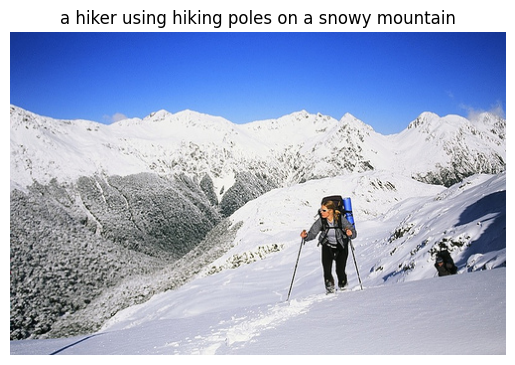

In [15]:

# Testing
test_image_caption(list(features.keys())[0])
